# Metacells 
> This module provides tools to construct metacells and perform pseudobulking within single-cell datasets. It includes methods for aggregating single-cell data into metacells and generating pseudobulk profiles for downstream analysis. These approaches are still under development and intended for exploratory use, with manual validation of generated metacells and pseudobulk profiles being essential.  


In [1]:
#| hide
from nbdev.showdoc import *

In [2]:
#| default_exp metacells


In [3]:
import scanpy as sc
from anndata import AnnData
from typing import Optional, List

def create_pseudobulk_samples(adata: AnnData, 
                              donor_column: Optional[str] = None, 
                              cell_type_column: Optional[str] = None, 
                              metadata_columns: Optional[List[str]] = None,
                              agg_func: str = "sum") -> AnnData:
    """Create pseudobulk samples from single-cell data.

    Parameters:
    adata (AnnData): Annotated data matrix.
    donor_column (str or None): Column name in `adata.obs` for donor information. If None, grouping will be done only using cell type.
    cell_type_column (str or None): Column name in `adata.obs` for cell type information. If None, grouping will be done only using donor.
    metadata_columns (list, optional): List of additional metadata columns to include.
    agg_func (str): Aggregation function to use across cells. Options are 'sum' or 'mean'. Default is 'sum'.

    Returns:
    AnnData: Combined pseudobulk samples as an AnnData object.
    """
    if metadata_columns is None:
        metadata_columns = []

    pseudobulk_list = []

    # Determine which columns are provided for grouping.
    grouping_keys = []
    if donor_column is not None:
        grouping_keys.append(donor_column)
    if cell_type_column is not None:
        grouping_keys.append(cell_type_column)

    def aggregate_counts(subset):
        if agg_func == "sum":
            counts = subset.X.sum(axis=0)
        elif agg_func == "mean":
            counts = subset.X.mean(axis=0)
        else:
            raise ValueError(f"Unsupported aggregation function: {agg_func}. Supported options are 'sum' and 'mean'.")
        if counts.ndim == 1:
            counts = counts.reshape(1, -1)
        return counts

    if grouping_keys:
        # Group by the available keys.
        for group_key, group_df in adata.obs.groupby(grouping_keys):
            # Ensure group_key is a tuple for consistent handling.
            if not isinstance(group_key, tuple):
                group_key = (group_key,)

            # Subset the data using the indices from the grouping.
            subset = adata[group_df.index, :]

            # Compute aggregated pseudobulk counts.
            pseudobulk_counts = aggregate_counts(subset)

            # Create an AnnData object for the pseudobulk sample with counts in .X.
            pseudobulk_adata = AnnData(X=pseudobulk_counts, var=subset.var[[]])

            # Construct a sample name by joining the group values.
            sample_name = "_".join([str(x) for x in group_key])
            pseudobulk_adata.obs_names = [sample_name]

            # Add the grouping metadata to the pseudobulk AnnData.
            for col, val in zip(grouping_keys, group_key):
                pseudobulk_adata.obs[col] = val

            # Add additional metadata columns if provided (assuming consistency within groups).
            for metadata in metadata_columns:
                pseudobulk_adata.obs[metadata] = subset.obs[metadata].iloc[0]

            pseudobulk_list.append(pseudobulk_adata)
    else:
        # If no grouping key is provided, aggregate all cells into one pseudobulk sample.
        subset = adata
        pseudobulk_counts = aggregate_counts(subset)
        pseudobulk_adata = AnnData(X=pseudobulk_counts, var=subset.var[[]])
        pseudobulk_adata.obs_names = ["all"]

        # Add additional metadata columns if provided, taking the value from the first cell.
        for metadata in metadata_columns:
            pseudobulk_adata.obs[metadata] = subset.obs[metadata].iloc[0]

        pseudobulk_list.append(pseudobulk_adata)

    # Combine all pseudobulk samples into a single AnnData object.
    pseudobulk_adata_combined = sc.concat(pseudobulk_list)
    pseudobulk_adata_combined.var['geneId'] = adata.var['geneId']
    pseudobulk_adata_combined.var_names = adata.var_names

    return pseudobulk_adata_combined


In [4]:
import allos.preprocessing as pp

In [5]:
mouse_data = pp.process_mouse_data()


🔎 Looking for file at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File found at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/e18.mouse.clusters.csv
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt.gz to /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_1.txt...
✅ Decompression complete.
Test data (mouse_1) downloaded successfully
✅ File already exists at: /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz

🔄 Decompressing /data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/allos/resources/data/mouse_2.txt.gz to 

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
mouse_data

View of AnnData object with n_obs × n_vars = 1109 × 31986
    obs: 'batch', 'cell_type'
    var: 'geneId'

In [7]:
mouse_data = pp.filter_transcripts_by_abundance(mouse_data, threshold_pct = 2)

In [8]:
mouse_data

AnnData object with n_obs × n_vars = 1109 × 24917
    obs: 'batch', 'cell_type'
    var: 'geneId'

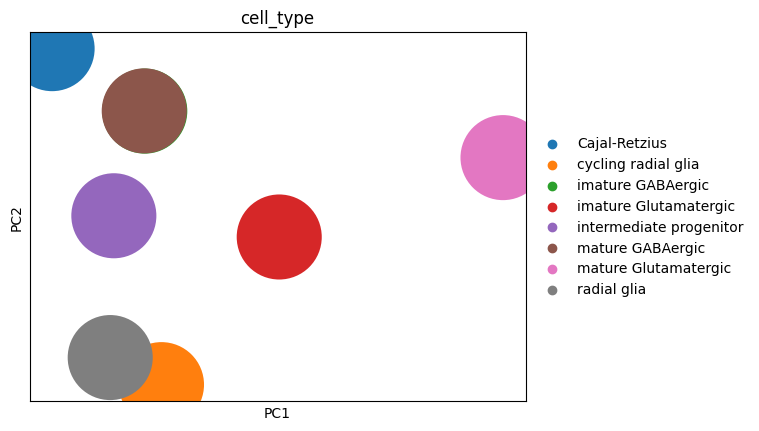

In [9]:
psuedobulk = create_pseudobulk_samples(mouse_data, cell_type_column='cell_type', donor_column=None)
sc.tl.pca(psuedobulk)
# Ensure that the 'cell_type' metadata is treated as a categorical variable to avoid the unary '-' TypeError
psuedobulk.obs['cell_type'] = psuedobulk.obs['cell_type'].astype('category')
sc.pl.pca(psuedobulk, color='cell_type')

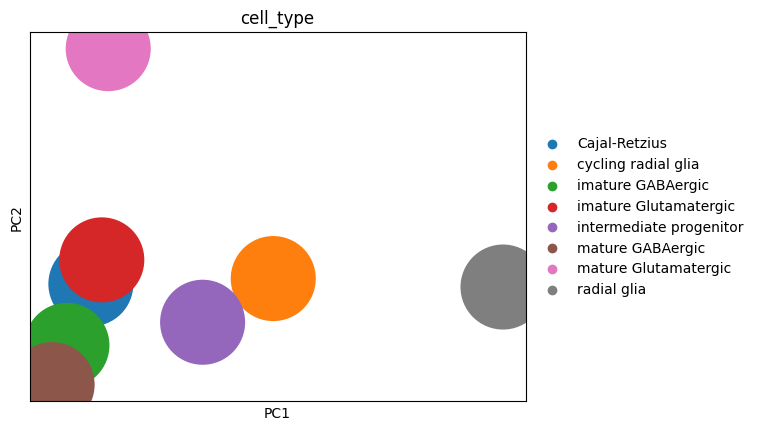

In [10]:
psuedobulk = create_pseudobulk_samples(mouse_data, cell_type_column='cell_type', donor_column=None, agg_func = 'mean')
sc.tl.pca(psuedobulk)
# Ensure that the 'cell_type' metadata is treated as a categorical variable to avoid the unary '-' TypeError
psuedobulk.obs['cell_type'] = psuedobulk.obs['cell_type'].astype('category')
sc.pl.pca(psuedobulk, color='cell_type')

In [11]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
from sklearn.neighbors import NearestNeighbors
from typing import Optional

def create_metacells(adata: AnnData,
                     donor_column: Optional[str] = None,
                     cell_type_column: Optional[str] = None,
                     n_neighbors: int = 30,
                     bagging_fraction: float = 0.8,
                     n_pcs: int = 50,
                     random_state: int = 0,
                     agg_func: str = 'mean') -> AnnData:
    """
    Create metacells by KNN bagging while retaining cell type and donor labels.
    
    For each group (e.g. defined by donor and/or cell type), the function:
      1. Computes PCA using a number of components that does not exceed the available data dimensions.
         If the calculated number equals min(n_samples, n_features) and that value is >1, it is reduced by one.
      2. Uses NearestNeighbors to find each cell’s neighbors.
      3. For each cell, a fraction of the candidate neighbors (including the cell itself)
         is randomly sampled and aggregated (using either mean or sum) to create a metacell.
      4. The group’s metadata (donor and cell type) is stored in the resulting metacell.
    
    Parameters:
      adata: AnnData object with single-cell data.
      donor_column: Column in adata.obs for donor info.
      cell_type_column: Column in adata.obs for cell type info.
      n_neighbors: Number of neighbors (excluding self) to consider.
      bagging_fraction: Fraction of candidate neighbors (including self) to sample.
      n_pcs: Desired number of principal components (will be reduced if group is small).
      random_state: Seed for reproducibility.
      agg_func: Aggregation function to combine counts, either 'mean' or 'sum'.
    
    Returns:
      An AnnData object containing metacell profiles.
    """
    np.random.seed(random_state)
    metacell_list = []

    # Build grouping keys.
    grouping_keys = []
    if donor_column is not None:
        grouping_keys.append(donor_column)
    if cell_type_column is not None:
        grouping_keys.append(cell_type_column)

    def process_subset(subset: AnnData, group_info: dict):
        # If there is only one cell, bypass PCA.
        if subset.shape[0] < 2:
            if hasattr(subset.X, "toarray"):
                subset.obsm['X_pca'] = subset.X.toarray()
            else:
                subset.obsm['X_pca'] = subset.X
        else:
            # Calculate the minimum dimension.
            min_dim = min(subset.shape[0], subset.shape[1])
            n_components = min(n_pcs, min_dim)
            # For svd_solver='arpack', n_components must be strictly less than min_dim.
            if n_components == min_dim and min_dim > 1:
                n_components = min_dim - 1
            sc.pp.pca(subset, n_comps=n_components, random_state=random_state)
        
        # Adjust neighbor search so we don't request more neighbors than cells.
        effective_neighbors = min(n_neighbors + 1, subset.shape[0])
        nbrs = NearestNeighbors(n_neighbors=effective_neighbors, metric='euclidean')\
                .fit(subset.obsm['X_pca'])
        knn_indices = nbrs.kneighbors(subset.obsm['X_pca'], return_distance=False)
        
        # For each cell, form a metacell by sampling a fraction of its neighbors.
        for i, cell in enumerate(subset.obs_names):
            candidate_indices = knn_indices[i]
            bag_size = max(1, int(np.ceil(bagging_fraction * len(candidate_indices))))
            sampled = np.random.choice(candidate_indices, size=bag_size, replace=False)
            expr_subset = subset.X[sampled]
            if hasattr(expr_subset, "toarray"):
                expr_subset = expr_subset.toarray()
            if agg_func == 'mean':
                metacell_expr = expr_subset.mean(axis=0)
            elif agg_func == 'sum':
                metacell_expr = expr_subset.sum(axis=0)
            else:
                raise ValueError("Invalid agg_func. Choose either 'mean' or 'sum'.")
            metacell = AnnData(X=metacell_expr.reshape(1, -1), var=subset.var.copy())
            meta = group_info.copy()
            meta['seed_cell'] = cell
            metacell.obs = pd.DataFrame(meta, index=[f"{cell}_metacell"])
            metacell_list.append(metacell)

    if grouping_keys:
        # Process each group so that metacells never mix donors or cell types.
        grouped = adata.obs.groupby(grouping_keys)
        for group_key, group_df in grouped:
            if not isinstance(group_key, tuple):
                group_key = (group_key,)
            group_info = {key: val for key, val in zip(grouping_keys, group_key)}
            subset = adata[group_df.index].copy()
            process_subset(subset, group_info)
    else:
        process_subset(adata.copy(), {})

    metacells_combined = sc.concat(metacell_list)
    metacells_combined.var_names = adata.var_names
    metacells_combined.var['geneId'] = adata.var['geneId']
    return metacells_combined


/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 24917 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


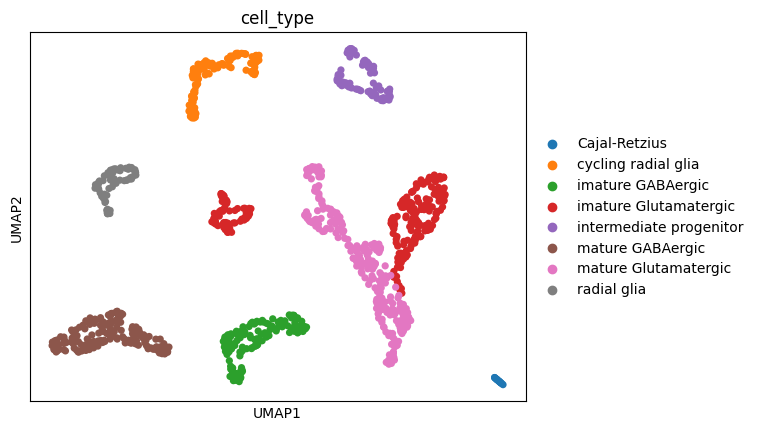

In [12]:
metacells = create_metacells(mouse_data, cell_type_column='cell_type')
sc.pp.neighbors(metacells)
# Ensure that the 'cell_type' metadata is treated as a categorical variable to avoid the unary '-' TypeError
metacells.obs['cell_type'] = metacells.obs['cell_type'].astype('category')
sc.tl.umap(metacells)
sc.pl.umap(metacells, color='cell_type')

/data/analysis/data_mcandrew/Allos_new/allos_env/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 24917 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


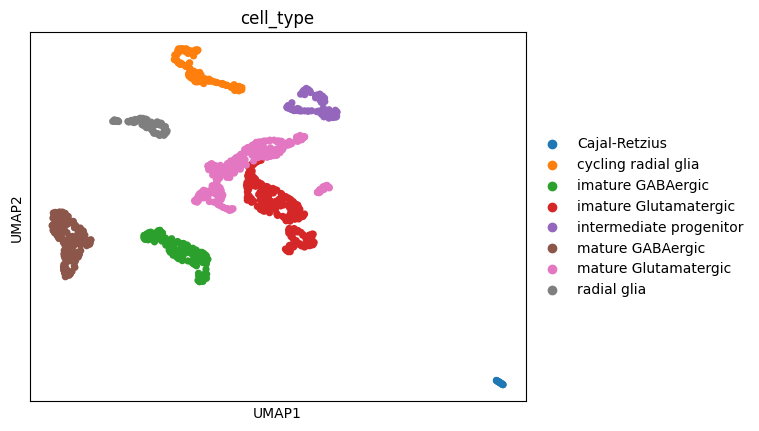

In [13]:
metacells = create_metacells(mouse_data, cell_type_column='cell_type', agg_func='sum')
sc.pp.neighbors(metacells)
# Ensure that the 'cell_type' metadata is treated as a categorical variable to avoid the unary '-' TypeError
metacells.obs['cell_type'] = metacells.obs['cell_type'].astype('category')
sc.tl.umap(metacells)
sc.pl.umap(metacells, color='cell_type')

In [14]:
from allos.switch_search import SwitchSearch

In [15]:
ss = SwitchSearch(metacells)

In [16]:
metacells.var

,geneId
transcriptId,
ENSMUST00000156717.1,Klc2
ENSMUST00000212520.1,Capn15
ENSMUST00000025798.12,Klc2
ENSMUST00000231280.1,Eva1c
ENSMUST00000039286.4,Atg5
...,...
ENSMUST00000213971.1,Zfp445
ENSMUST00000047275.7,Bace2
ENSMUST00000019994.13,Popdc3


In [17]:
switches = ss.find_switching_isoforms_wilcoxon(n_jobs=10, cell_group_column='cell_type')

In [18]:
switches.sort_values(by='pvals_adj', ascending= False)

,transcript_id,scores,log_fold_change,pvals,pvals_adj,group_1,group_2,contrast,gene_id,n_cells_group_1,n_cells_group_2,total_cells,p_value,direction,percent_expressed_group_1,percent_expressed_group_2
32987,ENSMUST00000164893.7,5.225940,33.510654,1.732727e-07,1.214469e-06,mature GABAergic,Cajal-Retzius,Cajal-Retzius__mature GABAergic,Nol4,172,16,188,1.214528e-06,-33.510654,79.069767,0.000000
54957,ENSMUST00000024056.9,5.259562,0.983016,1.443985e-07,1.031530e-06,mature GABAergic,Cajal-Retzius,Cajal-Retzius__mature GABAergic,Ube2j2,172,16,188,1.031979e-06,-0.983016,100.000000,100.000000
43037,ENSMUST00000106599.7,5.317202,1.225731,1.053753e-07,7.742956e-07,mature GABAergic,Cajal-Retzius,Cajal-Retzius__mature GABAergic,Rpl38,172,16,188,7.751318e-07,-1.225731,98.255814,100.000000
57332,ENSMUST00000115258.8,5.338022,33.390598,9.396606e-08,7.056517e-07,imature GABAergic,Cajal-Retzius,Cajal-Retzius__imature GABAergic,Zcchc12,141,16,157,7.064480e-07,-33.390598,81.560284,0.000000
16140,ENSMUST00000035934.6,5.346021,0.738823,8.990872e-08,6.697326e-07,mature GABAergic,Cajal-Retzius,Cajal-Retzius__mature GABAergic,Exoc3,172,16,188,6.707262e-07,-0.738823,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,ENSMUST00000114934.10,17.758089,3.007974,1.492280e-70,5.468108e-68,mature GABAergic,mature Glutamatergic,mature GABAergic__mature Glutamatergic,Celf2,172,275,447,1.759541e-65,3.007974,100.000000,92.727273
14082,ENSMUST00000115559.9,17.797220,36.442566,7.426388e-71,3.672421e-68,mature Glutamatergic,mature GABAergic,mature GABAergic__mature Glutamatergic,Dync1i1,275,172,447,1.246295e-65,-36.442566,100.000000,0.000000
31168,ENSMUST00000164181.1,17.854618,0.583592,2.660910e-71,5.765383e-69,mature Glutamatergic,imature Glutamatergic,imature Glutamatergic__mature Glutamatergic,Myl6,275,234,509,3.113507e-66,-0.583592,100.000000,100.000000
28909,ENSMUST00000110907.7,18.555452,2.953794,7.368487e-77,2.585924e-74,imature Glutamatergic,mature Glutamatergic,imature Glutamatergic__mature Glutamatergic,Meis2,234,275,509,2.261919e-71,2.953794,100.000000,80.363636


In [19]:
import allos.visuals as vs 

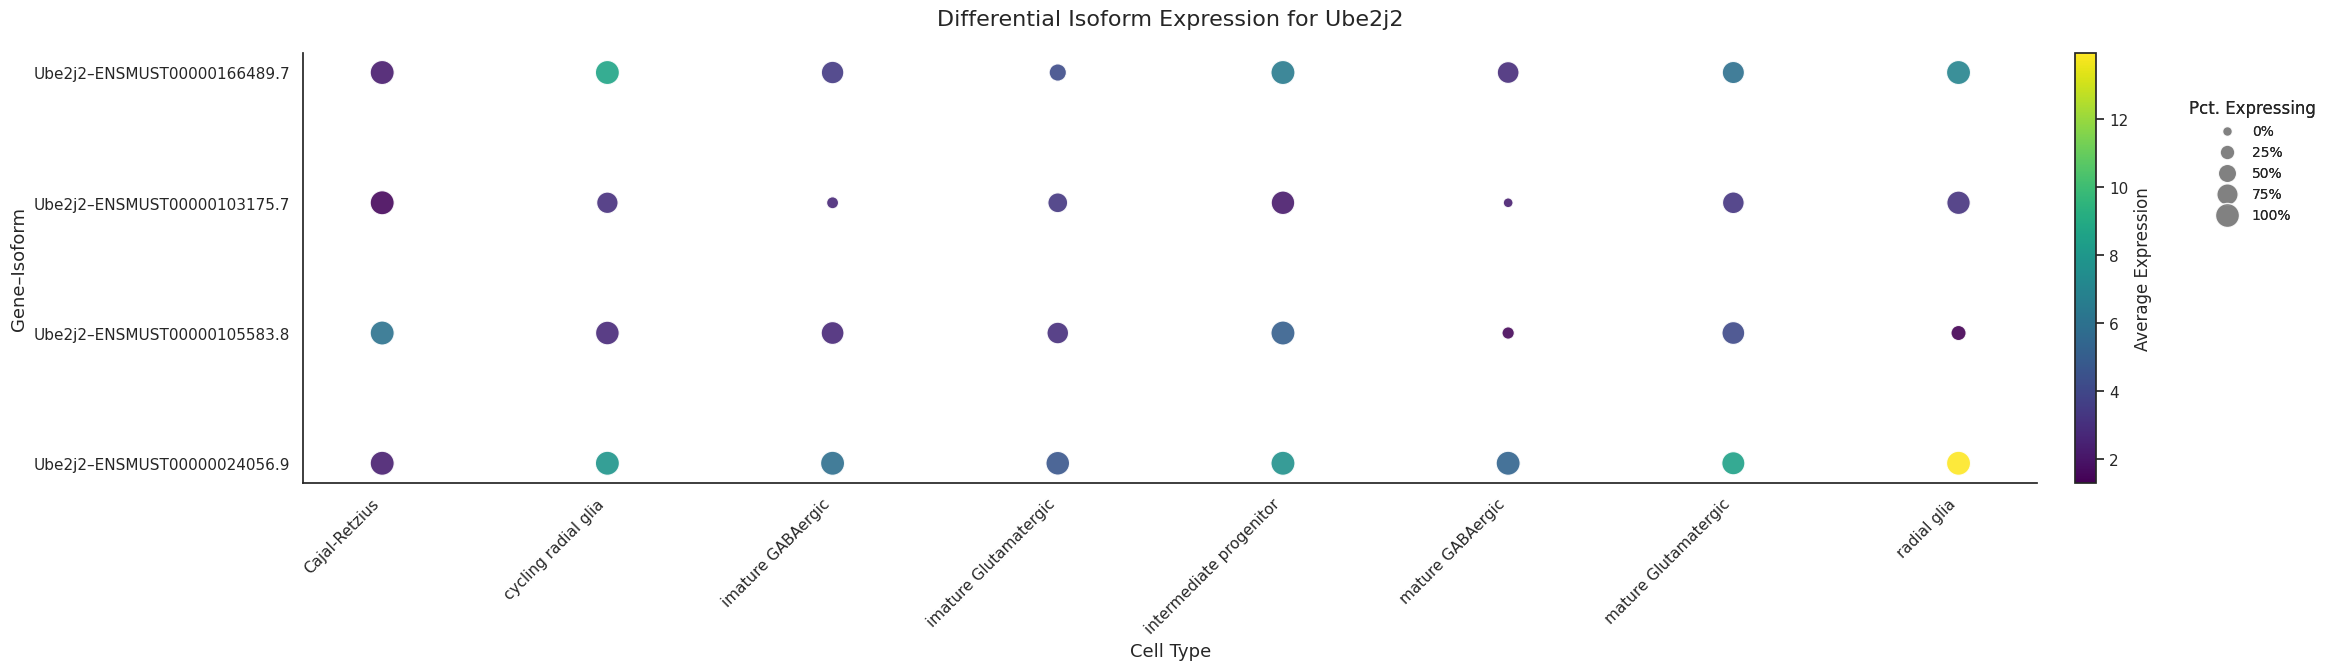

In [20]:
vs.plot_transcript_exspression_dotplot(metacells, gene_id='Nol4')

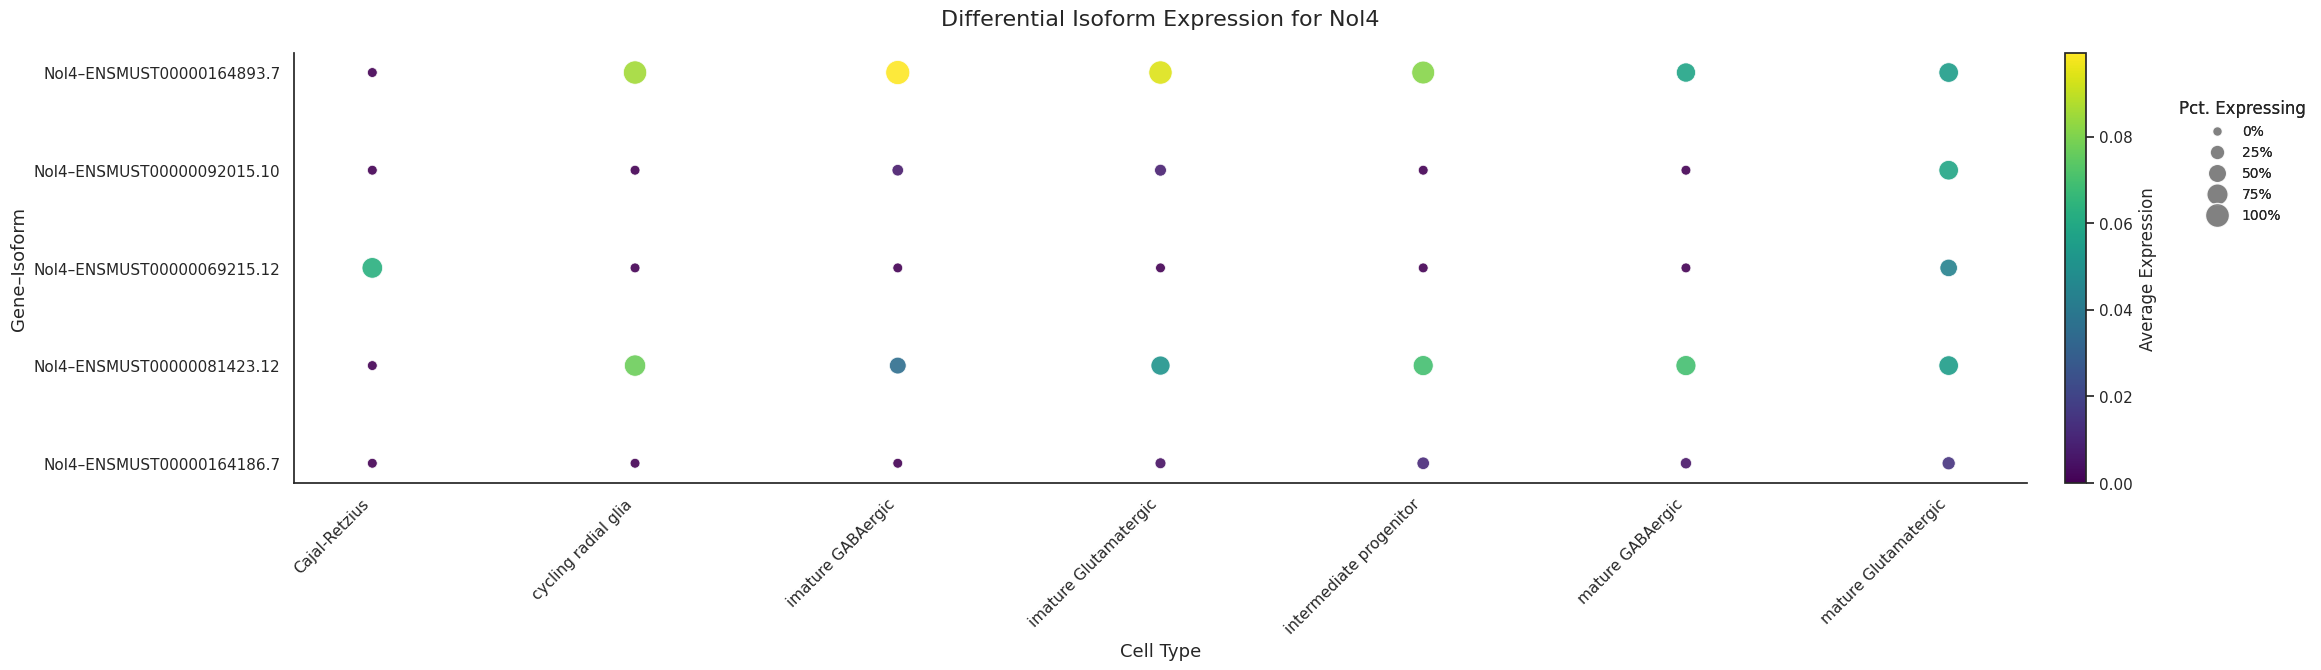

In [22]:
vs.plot_transcript_exspression_dotplot(mouse_data, gene_id='Nol4')